# VAE-GAN for Traffic Sign Generation

This notebook implements a Variational Autoencoder - Generative Adversarial Network (VAE-GAN) to generate images of traffic signs. The dataset used is `trafic_32`.

The goal is to:
1. Load and preprocess the traffic sign image data.
2. Define the VAE components (Encoder, Decoder) and GAN component (Discriminator). The Decoder also acts as the Generator.
3. Implement the combined VAE-GAN training logic.
4. Train the model.
5. Generate 1000 sample images and save them as a PyTorch tensor.

In [223]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.optim.lr_scheduler import CosineAnnealingLR

manualSeed = 999
#manualSeed = random.randint(1, 10000)

print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

Random Seed:  999


In [ ]:
DATA_ROOT = "trafic_32"
WORKERS = 4
BATCH_SIZE = 64
IMAGE_SIZE = 32
CHANNELS = 3
LATENT_DIM = 512
BASE_C_SIZE_G = 32
BASE_C_SIZE_D = 64
BASE_C_SIZE_E = 32
NUM_EPOCHS = 50
LR = 0.0004
BETA1 = 0.3

KLD_WEIGHT = 0.3
RECON_WEIGHT = 2.5
GAN_WEIGHT_G = 0.7


In [225]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


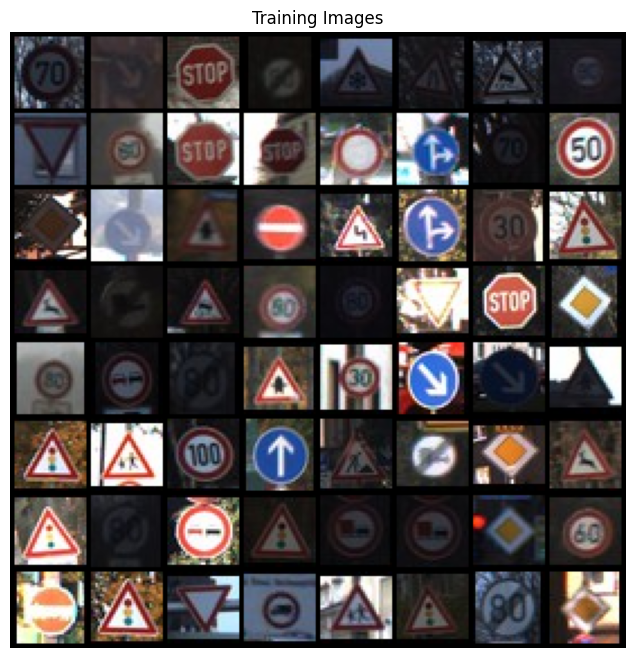

In [226]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = dset.ImageFolder(root=DATA_ROOT, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=WORKERS)

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [227]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels, base_channel_size, latent_dim, act_fn=nn.GELU):
        super().__init__()
        c_hid = base_channel_size
        self.net_conv = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=4, stride=2, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, c_hid * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c_hid * 2),
            act_fn(),
            nn.Conv2d(c_hid * 2, c_hid * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c_hid * 4),
            act_fn(),
            nn.Flatten()
        )
        self.fc_mean = nn.Linear(c_hid * 4 * 4 * 4, latent_dim)
        self.fc_log_var = nn.Linear(c_hid * 4 * 4 * 4, latent_dim)

    def forward(self, x):
        x_conv = self.net_conv(x)
        mean = self.fc_mean(x_conv)
        log_var = self.fc_log_var(x_conv)
        return mean, log_var

class Decoder(nn.Module):
    def __init__(self, num_output_channels, base_channel_size, latent_dim, act_fn=nn.GELU):
        super().__init__()
        c_hid = base_channel_size
        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, c_hid * 4 * 4 * 4),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(c_hid * 4, c_hid * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c_hid * 2),
            act_fn(),
            nn.ConvTranspose2d(c_hid * 2, c_hid, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(c_hid),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_output_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.latent_to_features(x)
        x = x.view(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, num_input_channels, base_channel_size):
        super().__init__()
        c_hid = base_channel_size
        self.main = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c_hid, c_hid * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(c_hid * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c_hid * 2, c_hid * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(c_hid * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(c_hid * 4, 1, 4, 1, 0, bias=False),
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [228]:
def reparameterize(mean, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mean + eps * std

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [229]:
encoder = Encoder(CHANNELS, BASE_C_SIZE_E, LATENT_DIM).to(device)
generator = Decoder(CHANNELS, BASE_C_SIZE_G, LATENT_DIM).to(device)
discriminator = Discriminator(CHANNELS, BASE_C_SIZE_D).to(device)

encoder.apply(weights_init)
generator.apply(weights_init)
discriminator.apply(weights_init)

print(encoder)
print(generator)
print(discriminator)

adversarial_loss_fn = nn.BCEWithLogitsLoss()
reconstruction_loss_fn = nn.L1Loss()

optimizerE = optim.Adam(encoder.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=LR*0.5, betas=(BETA1, 0.999))

scheduler_E = CosineAnnealingLR(optimizerE, T_max=100, eta_min=1e-6)
scheduler_G = CosineAnnealingLR(optimizerG, T_max=100, eta_min=1e-6)
scheduler_D = CosineAnnealingLR(optimizerD, T_max=100, eta_min=1e-6)

fixed_noise_vis = torch.randn(64, LATENT_DIM, device=device)

real_label_val = 1.
fake_label_val = 0.

Encoder(
  (net_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): GELU(approximate='none')
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mean): Linear(in_features=2048, out_features=512, bias=True)
  (fc_log_var): Linear(in_features=2048, out_features=512, bias=True)
)
Decoder(
  (latent_to_features): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): GELU(approximate='none')
  )
  (net): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(6

In [230]:
## Optionally load the models
# encoder.load_state_dict(torch.load("encoder.pth"))
# generator.load_state_dict(torch.load("generator.pth"))
# discriminator.load_state_dict(torch.load("discriminator.pth"))

In [231]:
img_list = []
G_losses = []
D_losses = []
Recon_losses = []
KLD_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(dataloader, 0):
        real_images = data[0].to(device)
        b_size = real_images.size(0)

        real_label = torch.full((b_size,), real_label_val, dtype=torch.float, device=device)
        fake_label = torch.full((b_size,), fake_label_val, dtype=torch.float, device=device)

        discriminator.zero_grad()

        output_real = discriminator(real_images)
        errD_real = adversarial_loss_fn(output_real, real_label)
        errD_real.backward()
        D_x = output_real.mean().item()

        noise_prior = torch.randn(b_size, LATENT_DIM, device=device)
        fake_images_prior = generator(noise_prior)
        output_fake_prior = discriminator(fake_images_prior.detach())
        errD_fake_prior = adversarial_loss_fn(output_fake_prior, fake_label)
        errD_fake_prior.backward()
        D_G_z1 = output_fake_prior.mean().item()

        errD = errD_real + errD_fake_prior
        optimizerD.step()

        encoder.zero_grad()
        generator.zero_grad()

        mean, log_var = encoder(real_images)
        z_reparam = reparameterize(mean, log_var)
        reconstructed_images = generator(z_reparam)

        err_recon = reconstruction_loss_fn(reconstructed_images, real_images)
        err_kld = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        err_kld /= (b_size * CHANNELS * IMAGE_SIZE * IMAGE_SIZE)

        noise_g_adv = torch.randn(b_size, LATENT_DIM, device=device)
        fake_images_g_adv = generator(noise_g_adv)
        output_g_adv = discriminator(fake_images_g_adv)
        errG_adv = adversarial_loss_fn(output_g_adv, real_label)
        D_G_z2 = output_g_adv.mean().item()

        total_err_EG = RECON_WEIGHT * err_recon + KLD_WEIGHT * err_kld + GAN_WEIGHT_G * errG_adv
        total_err_EG.backward()

        optimizerE.step()
        optimizerG.step()

        G_losses.append(errG_adv.item())
        D_losses.append(errD.item())
        Recon_losses.append(err_recon.item())
        KLD_losses.append(err_kld.item())

        if i % 50 == 0:
            print(f'[{epoch+1}/{NUM_EPOCHS}][{i}/{len(dataloader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G_adv: {errG_adv.item():.4f} '
                  f'Loss_Recon: {err_recon.item():.4f} Loss_KLD: {err_kld.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z1)): {D_G_z1:.4f} D(G(z2)): {D_G_z2:.4f}')

        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_vis = generator(fixed_noise_vis).detach().cpu()
            img_list.append(vutils.make_grid(fake_vis, padding=2, normalize=True))

        iters += 1
    
    scheduler_G.step()
    scheduler_D.step()
    scheduler_E.step()

print("Training finished.")

Starting Training Loop...
[1/3][0/613] Loss_D: 1.4204 Loss_G_adv: 1.1698 Loss_Recon: 0.5366 Loss_KLD: 0.0186 D(x): 0.2073 D(G(z1)): 0.0699 D(G(z2)): -0.7353
[1/3][50/613] Loss_D: 0.9029 Loss_G_adv: 2.0090 Loss_Recon: 0.4037 Loss_KLD: 0.0727 D(x): 0.0101 D(G(z1)): -3.9638 D(G(z2)): -1.7380
[1/3][100/613] Loss_D: 0.4478 Loss_G_adv: 2.5015 Loss_Recon: 0.3232 Loss_KLD: 0.0593 D(x): 1.7783 D(G(z1)): -2.0902 D(G(z2)): -2.3841
[1/3][150/613] Loss_D: 0.9125 Loss_G_adv: 3.3844 Loss_Recon: 0.2818 Loss_KLD: 0.0754 D(x): 2.9303 D(G(z1)): 0.0233 D(G(z2)): -3.3299
[1/3][200/613] Loss_D: 0.6788 Loss_G_adv: 2.6902 Loss_Recon: 0.2786 Loss_KLD: 0.0909 D(x): 1.4905 D(G(z1)): -1.3939 D(G(z2)): -2.5974
[1/3][250/613] Loss_D: 0.2602 Loss_G_adv: 3.4753 Loss_Recon: 0.2613 Loss_KLD: 0.0995 D(x): 2.7411 D(G(z1)): -2.5942 D(G(z2)): -3.4268
[1/3][300/613] Loss_D: 0.6804 Loss_G_adv: 4.6569 Loss_Recon: 0.2295 Loss_KLD: 0.1129 D(x): 3.4262 D(G(z1)): -0.3570 D(G(z2)): -4.6413
[1/3][350/613] Loss_D: 0.4364 Loss_G_adv:

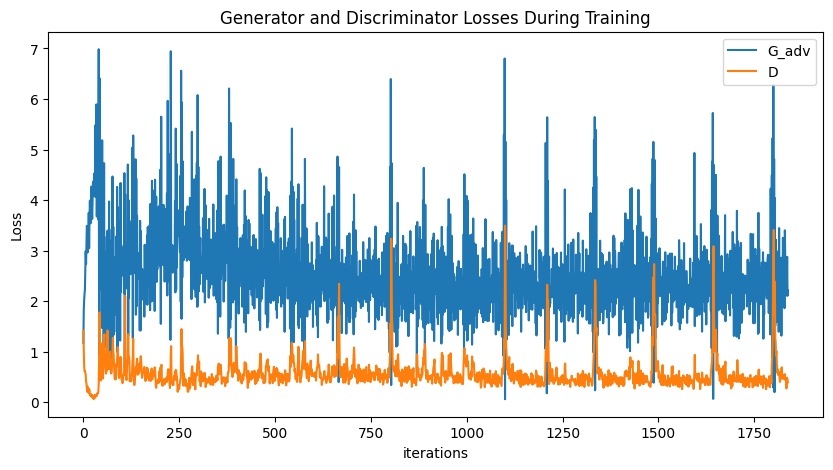

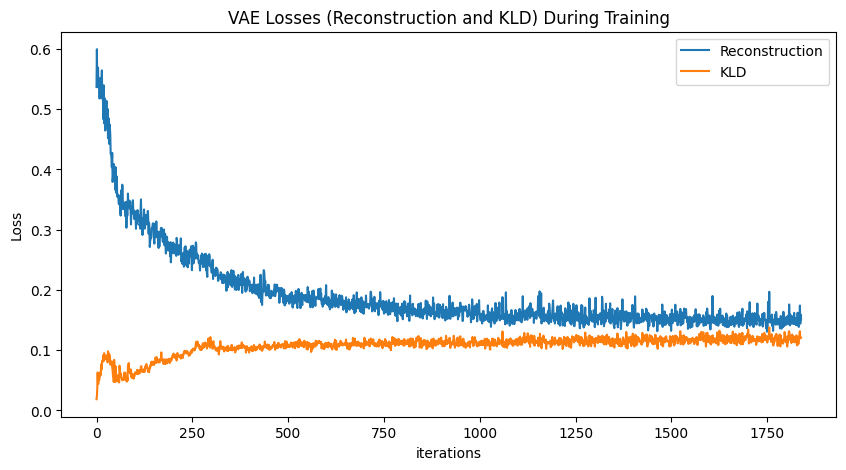

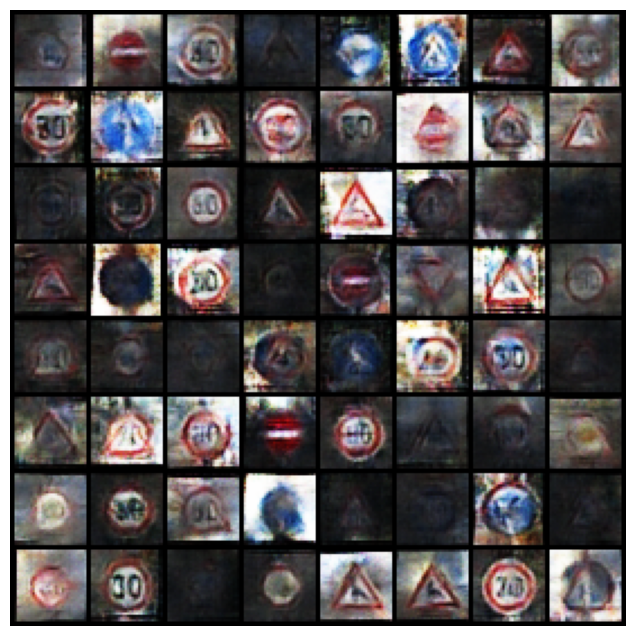

In [232]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Losses During Training")
plt.plot(G_losses,label="G_adv")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("VAE Losses (Reconstruction and KLD) During Training")
plt.plot(Recon_losses,label="Reconstruction")
plt.plot(KLD_losses,label="KLD")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Shape of generated images tensor: torch.Size([1000, 3, 32, 32])
Saved 1000 generated samples to poniedzialek_Matczuk_Szubzda.pt


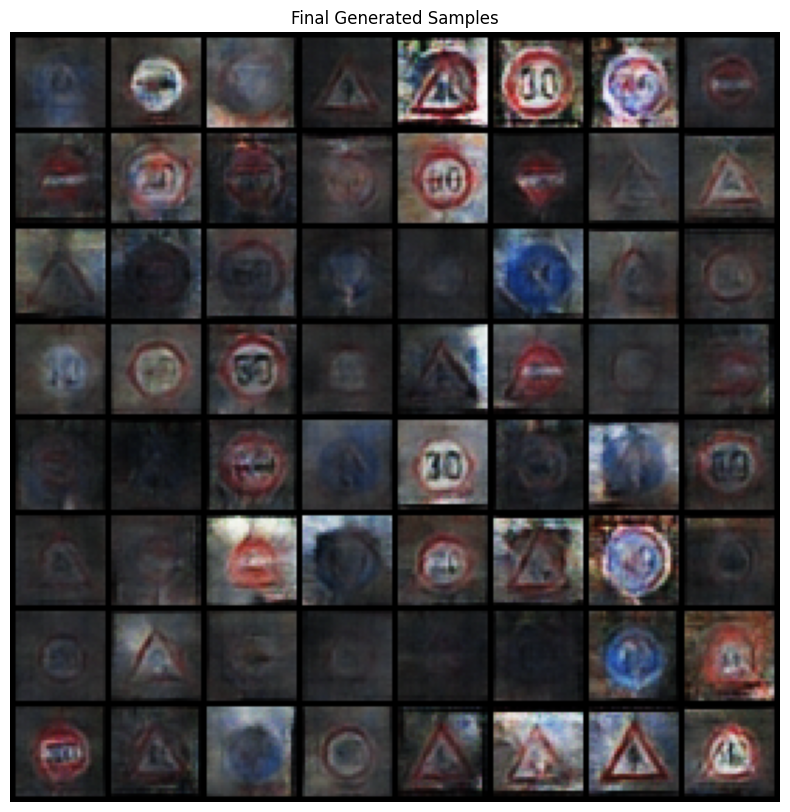

In [233]:
NUM_SAMPLES_TO_GENERATE = 1000
final_noise = torch.randn(NUM_SAMPLES_TO_GENERATE, LATENT_DIM, device=device)

generator.eval()
with torch.no_grad():
    generated_images = generator(final_noise).detach().cpu()

generated_images = generated_images * 0.5 + 0.5

print(f"Shape of generated images tensor: {generated_images.shape}")

output_filename = "poniedzialek_Matczuk_Szubzda.pt"
torch.save(generated_images, output_filename)
print(f"Saved {NUM_SAMPLES_TO_GENERATE} generated samples to {output_filename}")

torch.save(encoder.state_dict(), 'encoder_final.pth')
torch.save(generator.state_dict(), 'generator_final.pth')
torch.save(discriminator.state_dict(), 'discriminator_final.pth')

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Final Generated Samples")
plt.imshow(np.transpose(vutils.make_grid(generated_images[:64], padding=2, normalize=False).cpu(),(1,2,0)))
plt.show()